# Dynamic Models of Buildings and HVAC Controllers

Based on the approach used by Patel et al. (2016):

- N. R. Patel, M. J. Risbeck, J. B. Rawlings, M. J. Wen_zel and R. D. Turney, "Distributed economic model predictive control for large-scale building temperature regulation," 2016 American Control Conference (ACC), Boston, MA, USA, 2016, pp. 895-900, doi: 10.1109/ACC.2016.7525028. https://ieeexplore.ieee.org/document/7525028

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
import casadi as cas
from prettytable import PrettyTable
from plot_utils import make_tsplots, make_ioplots

## Building Temperature Models

Single zone model

$$C \frac{dT}{dt} = -H(T-T_a) - \dot{Q}_c + \dot{Q}_\text{other}$$

Multi-zone model

$$
C_i \frac{dT_i}{dt} = -H_i(T_i - T_a) - \sum_{j \ne i}{\beta_{ij}(T_i-T_j)} - \dot{Q}_{c,i} + \dot{Q}_{\text{other},i} \qquad  i=1,\dots,n_z
$$

Model of zone temperature controller (PI)

$$\dot{Q}_{c}=\dot{Q}_{ss} + K_{c} \left[ \varepsilon + \frac{1}{\tau_\text{I}}\int_0^t{\varepsilon(t') dt'} \right]$$

$$ \varepsilon = T_{\text{sp}} - T $$

Parameters

$$
\begin{array}{ll}
% \Delta & \text{ sample time of controller } \\
N & \text{ horizon length } \\
% c_k & \text{ cost of electricity at time } k \\
% c_{\text{peak }} & \text{ peak demand charge } \\
C & \text{ thermal capacitance } \\
H & \text{ scaled ambient heat transfer coefficient } \\
\beta_{i j} & \text{ scaled heat transfer coefficient between zones } \\
K_{\mathrm{c}, i} & \text{ scaled zone PI controller gain } \\
\tau_{\mathrm{I}, i} & \text{ integral time constant for zone PI controller } \\
\dot{Q}_{\mathrm{ss}, i} & \text{ steady-state rate of cooling } \\
% \eta & \text{ inverse of the aggregate COP } \\
% \dot{Q}_{\mathrm{HVAC}, \max } & \text{ max cooling capacity of HVAC system } \\
% \dot{Q}_{\text{peak,past }} & \text{ peak cooling rate previously achieved } \\
% \sigma & \text{ decay constant for storage tank } \\
% s_{\max } & \text{ max cooling capacity of storage tank } \\
T_{\min } & \text{ lower bound of comfort region } \\
T_{\max } & \text{ upper bound of comfort region } \\
% \mu & \text{ penalty on energy usage }
\end{array}
$$

Variables
$$
\begin{array}{ll}
t & \text{ time } \\
T & \text{ temperature } \\
T_a & \text{ ambient temperature } \\
T_{\text{sp }, i} & \text{ zone temperature setpoint } \\
\dot{Q}_{\text{other }} & \text{ external load, radiation, or disturbance } \\
\dot{Q}_c & \text{ cooling rate delivered } \\
Q_{\text{total }} & \text{ total amount of cooling delivered } \\
% \dot{Q}_{\text{HVAC }} & \text{ cooling rate from HVAC system } \\
% \dot{Q}_{\text{peak }} & \text{ peak HVAC system cooling rate } \\
% s & \text{ amount of cooling potential in storage tank } \\
% \dot{Q}_{\text{storage }} & \text{ cooling rate delivered to storage tank } \\
% \dot{Q}_{\text{HighLevel }} & \text{ cooling rate from high-level problem } \\
% T_{\text{HighLevel }} & \text{ building temperature from high-level problem } \\
\varepsilon_i & \text{ tracking error } \\
I_{\varepsilon_i} & \text{ integral of tracking error } \\
v_{\text{air }, i} & \text{ air flow rate in AHU }
\end{array}
$$

Nomenclature
$$
\begin{array}{ll}
i & \text{ zone index } \\
n_z & \text{ number of zones } \\
k & \text{ time index } \\
\end{array}
$$

Combined system model:

<img src="images/system_model_ct_upvwy.png" width="40%">

System model variables:

$$
\begin{array}{ll}
\mathbf{p}(t) & \text{ disturbance inputs } \\
\mathbf{u}(t) & \text{ manipulated variable inputs } \\
\mathbf{x}(t) & \text{ model states } \\
\mathbf{w}(t) & \text{ process noise (random) } \\
\mathbf{y}(t) & \text{ model outputs } \\
\mathbf{v}(t) & \text{ measurement noise (random) } \\
\mathbf{y}_M(t) & \text{ measured model outputs } \\
\end{array}
$$

## Simulate single zone with cooling and disturbance inputs

In this case, one state variable:

$$x(t) = T(t)$$

One manipulatable input:

$$u(t) = \dot{Q}_c$$

Two disturbance inputs:

$$\mathbf{p}(t) = \begin{bmatrix} T_a \\ \dot{Q}_\text{other} \end{bmatrix}$$

In [2]:
# Constants
C = 6.0  # thermal capacitance, kWh/K
H = 6/24   # scaled heat transfer coefficient with ambient, kW/K

# System dimensions
n_x = 1  # number of states
n_u = 1  # number of manipulated inputs
n_p = 2  # number of disturbance inputs

# Declare variables
x = cas.MX.sym('x', n_x)  # states
u = cas.MX.sym('u', n_u)  # manipulated inputs
p = cas.MX.sym('p', n_p)  # disturbance inputs

# Aliases
T = x[0]  # zone temperature
Q_c = u[0]  # cooling delivered
T_a = p[0]  # ambient temperature
Q_other = p[1]  # external heat load, e.g. insolation or disturbance

# Define ODE
dTdt = (-H * (T - T_a) - Q_c + Q_other) / C  # rate-of-change of zone temperature
inputs = cas.vertcat(u, p)
rhs = dTdt
f = cas.Function('f', [x, inputs], [rhs], ['x', 'u'], ['dxdt'])
print(f)

f:(x,u[3])->(dxdt) MXFunction


In [3]:
def convert_continuous_model_to_discrete(f, x, inputs, dt, number_of_finite_elements=1, solver='rk'):

    # Make integrator
    intg_options = {'number_of_finite_elements': number_of_finite_elements}
    dae = {'x': x, 'p': inputs, 'ode': f(x, inputs)}
    t0, tf = 0, dt / number_of_finite_elements
    intg = cas.integrator('intg', solver, dae, t0, tf, intg_options)

    # Discrete-time system model
    res = intg(x0=x, p=inputs)
    xf = res['xf']
    F = cas.Function('F', [x, inputs], [xf], ['xk', 'inputs_k'], ['xkp1'])

    return F

# Discrete-time system model
dt = 0.25  # timestep size, hours
F = convert_continuous_model_to_discrete(f, x, inputs, dt)
print(F)

F:(xk,inputs_k[3])->(xkp1) MXFunction


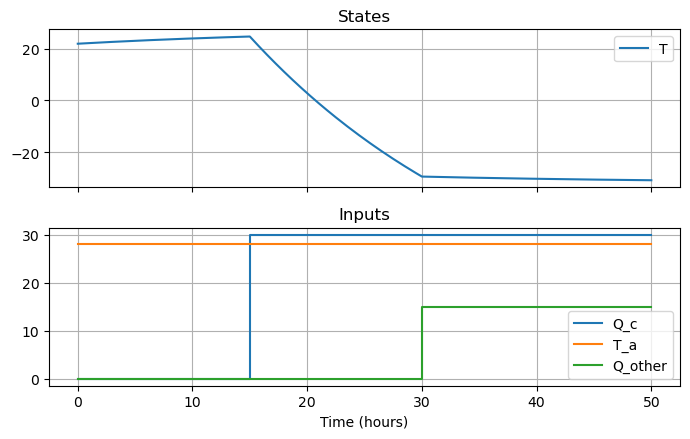

In [4]:
# Simulation inputs
N = 200
t = dt * np.arange(N + 1)
inputs = np.zeros((N + 1, n_u + n_p))
inputs[t >= 15, 0] = 30.0   # Q_c
inputs[:, 1] = 28.0  # T_a
inputs[t >= 30, 2] = 15.0   # Q_other

# Initial condition
x0 = 22.0  # zone temperature

def simulate_system(F, inputs, x0):
    N = inputs.shape[0] - 1
    X = []
    xk = x0
    for k in range(N + 1):
        X.append(xk)
        inputs_k = inputs[k, :].T
        xk = F(xk, inputs_k)
    return cas.hcat(X).T

# Simulation loop
X = simulate_system(F, inputs, x0)
X = np.array(X)

# Plot results
make_ioplots(
    t, 
    inputs=inputs, 
    states=X, 
    states_labels=['T'], 
    inputs_labels=['Q_c', 'T_a', 'Q_other']
)
plt.tight_layout()
plt.show()

## Zones with local (distributed) temperature controllers

System model:

<img src="images/system_model_cont_ct_upvwy.png" width="75%">

System model variables:

$$
\begin{array}{ll}
\mathbf{r}(t) & \text{ setpoint inputs } \\
\mathbf{\varepsilon}(t) & \text{ tracking errors } \\
\mathbf{p}(t) & \text{ disturbance inputs } \\
\mathbf{u}(t) & \text{ manipulated variable inputs } \\
\mathbf{x}(t) & \text{ model states } \\
\mathbf{w}(t) & \text{ process noise (random) } \\
\mathbf{y}(t) & \text{ model outputs } \\
\mathbf{v}(t) & \text{ measurement noise (random) } \\
\mathbf{y}_M(t) & \text{ measured model outputs } \\
\end{array}
$$

## PI controller with anti-windup

<img src="images/pi_controller_anti_windup.png" width="60%">


## Simulate single zone with cooling, disturbance inputs, and proportional controller

Combined system model:

<img src="images/system_model_ct_upvwy.png" width="40%">

In this case, one state variable:

$$x(t) = T(t)$$

One manipulatable input:

$$u(t) = T_{sp} $$

Two disturbance inputs:

$$\mathbf{p}(t) = \begin{bmatrix} T_a \\ \dot{Q}_\text{other} \end{bmatrix}$$

In [5]:
# Constants
C = 6.0  # thermal capacitance, kWh/K
H = 6/24   # scaled heat transfer coefficient with ambient, kW/K
K_c = -10  # controller gain parameter
Q_ss = 0    # steady-state rate of cooling

# System dimensions
n_x = 1  # number of states
n_u = 1  # number of manipulated inputs
n_p = 2  # number of disturbance inputs

# Declare variables
x = cas.MX.sym('x', n_x)  # states
u = cas.MX.sym('u', n_u)  # manipulated inputs
p = cas.MX.sym('p', n_p)  # disturbance inputs
inputs = cas.vertcat(u, p)

# Aliases
T = x  # zone temperature
T_sp = u[0]  # zone temperature setpoint
T_a = p[0]  # ambient temperature
Q_other = p[1]  # external heat load, e.g. insolation or disturbance

# Define ODE
eps = T_sp - T  # tracking error
Q_c = Q_ss + K_c * eps  # control action
dTdt = (-H * (T - T_a) - Q_c + Q_other) / C  # rate-of-change of zone temperature

rhs = dTdt
f = cas.Function('f', [x, inputs], [rhs], ['x', 'u'], ['dxdt'])
print(f)

f:(x,u[3])->(dxdt) MXFunction


In [6]:
# Discrete-time system model
dt = 0.25  # timestep size, hours
F = convert_continuous_model_to_discrete(f, x, inputs, dt)
print(F)

F:(xk,inputs_k[3])->(xkp1) MXFunction


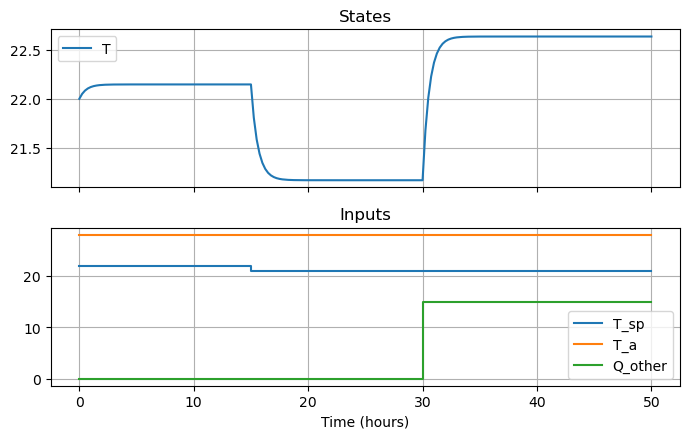

In [7]:
# Simulation inputs
N = 200
t = dt * np.arange(N + 1)
inputs = np.zeros((N + 1, n_u + n_p))
inputs[:, 0] = 22.0   # T_sp
inputs[t >= 15, 0] = 21.0   # T_sp
inputs[:, 1] = 28.0  # T_a
inputs[t >= 30, 2] = 15.0   # Q_other

# Initial condition
x0 = 22.0  # zone temperature

# Simulation loop
X = simulate_system(F, inputs, x0)
X = np.array(X)

# Plot results
make_ioplots(
    t, 
    inputs=inputs, 
    states=X, 
    states_labels=['T'], 
    inputs_labels=['T_sp', 'T_a', 'Q_other']
)
plt.tight_layout()
plt.show()

In [8]:
rmse_tracking = np.sqrt(np.mean((X[:, 0] - inputs[:, 0]) ** 2))
print(f"Tracking error: {rmse_tracking:.2f}")

Tracking error: 1.03


## Simulate single zone with cooling, disturbance inputs and PI controller

One state variable:

$$x(t) = T(t)$$

One manipulatable input:

$$\mathbf{u}(t) = T_{sp} $$

Two disturbance inputs:

$$\mathbf{p}(t) = \begin{bmatrix} T_a \\ \dot{Q}_\text{other} \end{bmatrix}$$

In [9]:
# Constants
C = 6.0  # thermal capacitance, kWh/K
H = 6/24   # scaled heat transfer coefficient with ambient, kW/K
K_c = -10  # controller gain parameter
tau_I = 1   # PI controller integral parameter
Q_ss = 0    # steady-state rate of cooling

# System dimensions
n_x = 2  # number of states
n_u = 1  # number of manipulated inputs
n_p = 2  # number of disturbance inputs

# Declare variables
x = cas.MX.sym('x', n_x)  # states
u = cas.MX.sym('u', n_u)  # manipulated inputs
p = cas.MX.sym('p', n_p)  # disturbance inputs
inputs = cas.vertcat(u, p)

# Aliases
T = x[0]  # zone temperature
I_eps = x[1]  # integral of tracking error
T_sp = u[0]  # zone temperature setpoint
T_a = p[0]  # ambient temperature
Q_other = p[1]  # external heat load, e.g. insolation or disturbance

# Define ODE
eps = T_sp - T  # tracking error
dI_eps_dt = eps
Q_c = Q_ss + K_c * (eps + I_eps / tau_I)  # control action
dTdt = (-H * (T - T_a) - Q_c + Q_other) / C  # rate-of-change of zone temperature

rhs = cas.vertcat(dTdt, dI_eps_dt)
f = cas.Function('f', [x, inputs], [rhs], ['x', 'u'], ['dxdt'])
print(f)

f:(x[2],u[3])->(dxdt[2]) MXFunction


In [10]:
# Discrete-time system model
dt = 0.25  # timestep size, hours
F = convert_continuous_model_to_discrete(f, x, inputs, dt)
print(F)

F:(xk[2],inputs_k[3])->(xkp1[2]) MXFunction


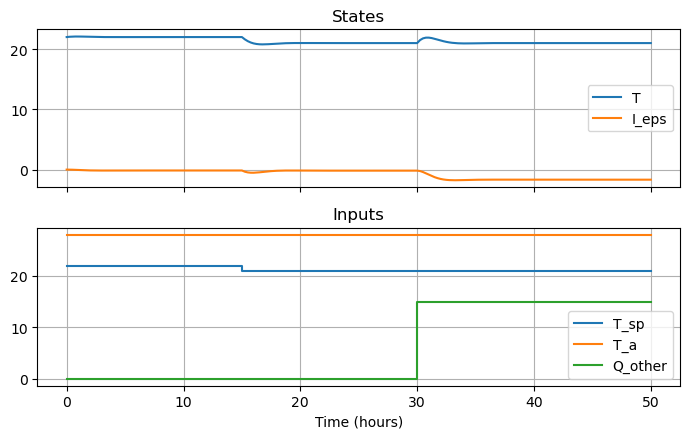

In [11]:
# Simulation inputs
N = 200
t = dt * np.arange(N + 1)
inputs = np.zeros((N + 1, n_u + n_p))
inputs[:, 0] = 22.0   # T_sp
inputs[t >= 15, 0] = 21.0   # T_sp
inputs[:, 1] = 28.0  # T_a
inputs[t >= 30, 2] = 15.0   # Q_other

# Initial condition
x0 = cas.vertcat(
    22.0,  # zone temperature
    0.0  # integral of tracking error
)

# Simulation loop
X = simulate_system(F, inputs, x0)
X = np.array(X)

# Plot results
make_ioplots(
    t, 
    inputs=inputs, 
    states=X, 
    states_labels=['T', 'I_eps'], 
    inputs_labels=['T_sp', 'T_a', 'Q_other']
)
plt.tight_layout()
plt.show()

In [12]:
rmse_tracking = np.sqrt(np.mean((X[:, 0] - inputs[:, 0]) ** 2))
print(f"Tracking error: {rmse_tracking:.2f}")

Tracking error: 0.18


## Simulate multiple zones with cooling, disturbance inputs and PI controllers

Continuous-time state space model:

$$
\dot{\mathbf{x}}(t) = f(
    \mathbf{x}(t), \mathbf{u}(t), \mathbf{p}(t)
) + \mathbf{w}(t)
$$

$$
\mathbf{y}(t) = h(
    \mathbf{x}(t), \mathbf{u}(t), \mathbf{p}(t)
) + \mathbf{v}(t)
$$

States:

$$
\mathbf{x}(t) = \begin{bmatrix}
    T_1(t) \\ \vdots \\ T_{n_z}(t) \\ 
    \bar{\varepsilon}_1(t) \\ \vdots \\ \bar{\varepsilon}_{n_z}(t) \\
\end{bmatrix}
$$

Manipulatable inputs:

$$
\mathbf{u}(t) = \begin{bmatrix}
    T_{sp,1} \\ \vdots \\ T_{sp,n_z}
\end{bmatrix}
$$

Disturbance inputs:

$$
\mathbf{p}(t) = \begin{bmatrix}
    \dot{Q}_{\text{other},1} \\ \vdots \\ \dot{Q}_{\text{other},n_z} \\
    T_a
\end{bmatrix}
$$

Outputs:

$$
\mathbf{y}(t) = \begin{bmatrix}
    \dot{Q}_{c,1} \\ \vdots \\ \dot{Q}_{c,n_z}
\end{bmatrix}
$$

In [13]:
from itertools import combinations

list(combinations([0, 1, 2], 2))

[(0, 1), (0, 2), (1, 2)]

In [14]:
def multi_zone_temp_ODEs(x, inputs, params):
    """Righthand side of the ODE for the system model of a multi-zone building.
    """

    # Parameters
    H = params['H']
    C = params['C']
    beta = params['beta']
    K_c = params['K_c']
    tau_I = params['tau_I']
    Q_ss = params['Q_ss']

    # number of zones
    n_z = x.shape[0] // 2

    # x, inputs must be vectors - doesn't support broadcasting
    try:
        assert x.ndim == 1
    except AttributeError:
        assert x.shape[1] == 1
    try:
        assert inputs.ndim == 1
    except AttributeError:
        assert inputs.shape[1] == 1
    assert inputs.shape[0] == 2*n_z + 1

    # State variables
    T = x[:n_z]  # zone temperatures
    I_eps = x[n_z:2*n_z]  # integral of tracking error

    # Inputs
    T_sp = inputs[:n_z]  # zone temperature setpoint
    Q_other = inputs[n_z:2*n_z]  # external heat load, e.g. insolation or disturbance
    T_a = inputs[2*n_z]  # ambient temperature

    # Zone controllers
    eps = T_sp - T  # tracking error
    Q_c = Q_ss + K_c * (eps + I_eps / tau_I)  # control action

    # Rate-of-change of zone temperature
    dTdt = (-H * (T - T_a) - Q_c + Q_other) / C

    # Rate-of-change of integral of error
    dI_eps_dt = eps

    # Add interactive effects between zones
    for i in range(n_z):
        for j in range(n_z):
            if j == i or beta[i, j] == 0.0:
                continue
            assert beta[i, j] == beta[j, i]
            dTdt[i] = dTdt[i] - beta[i, j] * (T[i] - T[j])

    return dTdt, dI_eps_dt


def multi_zone_temp_outputs(x, inputs, params):
    """Output function for the system model of a multi-zone building.
    """

    # Parameters
    K_c = params['K_c']
    tau_I = params['tau_I']
    Q_ss = params['Q_ss']

    # number of zones
    n_z = x.shape[0] // 2

    # x, inputs must be vectors - doesn't support broadcasting
    try:
        assert x.ndim == 1
    except AttributeError:
        assert x.shape[1] == 1
    try:
        assert inputs.ndim == 1
    except AttributeError:
        assert inputs.shape[1] == 1
    assert inputs.shape[0] == 2*n_z + 1

    # State variables
    T = x[:n_z]  # zone temperatures
    I_eps = x[n_z:2*n_z]  # integral of tracking error

    # Inputs
    T_sp = inputs[:n_z]  # zone temperature setpoint

    # Zone controllers
    eps = T_sp - T  # tracking error
    Q_c = Q_ss + K_c * (eps + I_eps / tau_I)  # control action

    return Q_c


In [15]:
def simulate_system_with_outputs(F, H, inputs, x0):
    N = inputs.shape[0] - 1
    X = []
    Y = []
    xk = x0
    for k in range(N + 1):
        X.append(xk)
        inputs_k = inputs[k, :].T
        yk = H(xk, inputs_k)
        Y.append(yk)
        xk = F(xk, inputs_k)
    return cas.hcat(X).T, cas.hcat(Y).T

In [16]:
# Parameters
three_zone_model_params = {
    "n_z": 3,  # # number of zones
    'C': cas.DM([6, 5, 7]),  # thermal capacitance, kWh/K  [6, 5, 7]
    'H': cas.DM([6/24, 6/24, 6/24]),  # scaled heat transfer coefficient with ambient, kW/K  [6/24, 5/23, 7/25]
    'beta': cas.DM([
        [0.   , 4/17 , 13/50 ],  # heat transfer coefficients between zones, kW/K
        [4/17 , 0.0  , 14/57 ],
        [13/50, 14/57, 0.    ]
    ]),
    'K_c': cas.DM([-10, -10, -10]),  # controller gain parameter, kW/K
    'tau_I': cas.DM([1, 1, 1]),  # PI controller integral parameter
    'Q_ss': cas.DM([0, 0, 0]),  # steady-state rate of cooling, kW
    'Tmin': 20.5,  # minimum comfort temperature bound
    'Tmax': 22.5,  # maximum comfort temperature bound
    'Q_HVAC_max': 30  # maximum cooling supply rate
}

params = three_zone_model_params

# Convert most params to CasADi constants
n_z = params['n_z']
params = {name: cas.DM(values) for name, values in params.items()}

# System dimensions
n_x = 2 * n_z  # number of states
n_u = n_z  # number of manipulated inputs
n_p = n_z + 1  # number of disturbance inputs
n_y = n_z  # number of outputs

# Declare variables
x = cas.MX.sym('x', n_x)
u = cas.MX.sym('u', n_u)
p = cas.MX.sym('p', n_p)
inputs = cas.vertcat(u, p)

# ODE equations
dTdt, dI_eps_dt = multi_zone_temp_ODEs(x, inputs, params)

# Define ODE
rhs = cas.vertcat(dTdt, dI_eps_dt)
f = cas.Function('f', [x, inputs], [rhs], ['x', 'inputs'], ['dxdt'])
print(f)

f:(x[6],inputs[7])->(dxdt[6]) MXFunction


In [17]:
# Discrete-time system model
dt = 0.25  # timestep size, hours
F = convert_continuous_model_to_discrete(f, x, inputs, dt)
print(F)

F:(xk[6],inputs_k[7])->(xkp1[6]) MXFunction


In [18]:
# Output equation
Q_c = multi_zone_temp_outputs(x, inputs, params)
H = cas.Function('H', [x, inputs], [Q_c], ['xk', 'inputs'], ['yk'])
print(H)

H:(xk[6],inputs[7])->(yk[3]) MXFunction


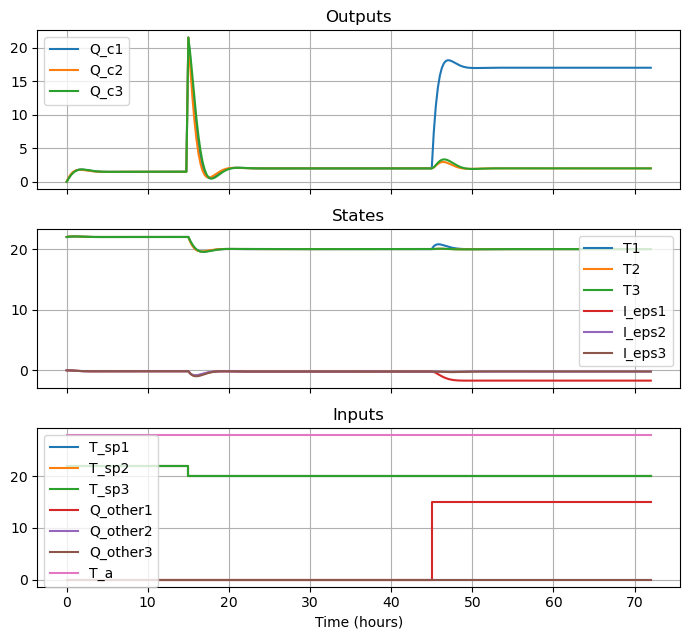

In [19]:
# Simulation inputs
t_stop = 72  # simulation duration, hours
dt = 0.25  # 
N = np.floor(t_stop / dt).astype(int)
t = dt * np.arange(N + 1)
inputs = np.zeros((N + 1, n_u + n_p))
inputs[:, 0] = 22.0   # T_sp1
inputs[:, 1] = 22.0   # T_sp2
inputs[:, 2] = 22.0   # T_sp3
inputs[t >= 15, 0:3] = 20.0  # Change all T_sp
inputs[t >= 45, 3] = 15.0   # Q_other1
inputs[t >= 45, 4] = 0.0   # Q_other2
inputs[t >= 45, 5] = 0.0   # Q_other3
inputs[:, 6] = 28.0  # T_a

# Initial condition
x0 = cas.vertcat(
    22.0,  # T1
    22.0,  # T2
    22.0,  # T3
    0.0,   # I_eps1
    0.0,   # I_eps2
    0.0,   # I_eps3
)

# Simulation loop
X, Y = simulate_system_with_outputs(F, H, inputs, x0)
X = np.array(X)
Y = np.array(Y)

# Plot results
inputs_labels = (
    [f'T_sp{i+1}' for i in range(n_z)] 
    + [f'Q_other{i+1}' for i in range(n_z)]
    + ['T_a']
)
states_labels = (
    [f'T{i+1}' for i in range(n_z)] 
    + [f'I_eps{i+1}' for i in range(n_z)]
)
outputs_labels = [f'Q_c{i+1}' for i in range(n_y)]

# Plot results
make_ioplots(
    t, 
    inputs=inputs, 
    states=X,
    outputs=Y,
    inputs_labels=inputs_labels,
    states_labels=states_labels, 
    outputs_labels=outputs_labels
)
plt.tight_layout()
plt.show()

In [20]:
rmse_tracking = np.sqrt(np.mean((X[:, 0:n_z] - inputs[:, 0:n_z]) ** 2))
print(f"Tracking error: {rmse_tracking:.2f}")

Tracking error: 0.17


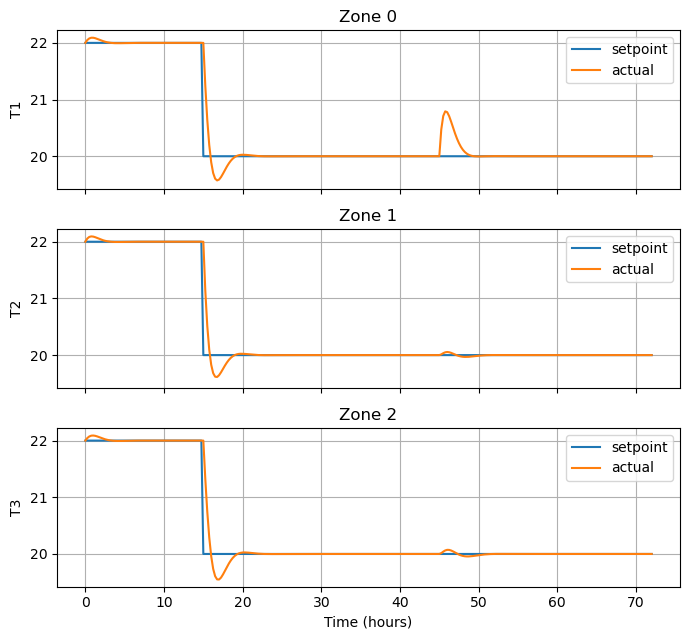

In [21]:
plot_data = {
    f"Zone {z}": {
        "y": np.stack([inputs[:, z], X[:, z]]).T, 
        "labels": ['setpoint', 'actual'], 
        "y_label": f"T{z+1}"
    } 
    for z in range(n_z)
}
make_tsplots(t, plot_data, sharey=True)
plt.tight_layout()
plt.show()

In [22]:
table = PrettyTable()
table.add_column("Time", t)
for i in range(n_z):
    table.add_column(f"T{i+1}", X[:, i].round(2))
table

Time,T1,T2,T3
0.0,22.0,22.0,22.0
0.25,22.05,22.06,22.04
0.5,22.08,22.09,22.07
0.75,22.09,22.09,22.09
1.0,22.09,22.09,22.09
1.25,22.08,22.08,22.08
1.5,22.07,22.07,22.07
1.75,22.06,22.05,22.06
2.0,22.04,22.04,22.05
2.25,22.03,22.03,22.04


## Control System using Model Predictive Control

### System model

In [23]:
params = three_zone_model_params

# Convert most params to CasADi constants
n_z = params['n_z']
params = {name: cas.DM(values) for name, values in params.items()}

# System dimensions
n_x = 2 * n_z  # number of states
n_u = n_z  # number of manipulated inputs
n_p = n_z + 1  # number of disturbance inputs

# Declare variables
x = cas.MX.sym('x', n_x)
u = cas.MX.sym('u', n_u)
p = cas.MX.sym('p', n_p)
inputs = cas.vertcat(u, p)

# ODE equations
dTdt, dI_eps_dt = multi_zone_temp_ODEs(x, inputs, params)

# Define ODE
rhs = cas.vertcat(dTdt, dI_eps_dt)
f = cas.Function('f', [x, inputs], [rhs], ['x', 'inputs'], ['dxdt'])

# Discrete-time system model
dt = 0.25  # length of 1 control interval
F = convert_continuous_model_to_discrete(f, x, inputs, dt)

# Output equation
Q_c = multi_zone_temp_outputs(x, inputs, params)
H = cas.Function('H', [x, inputs], [Q_c], ['xk', 'inputs'], ['yk'])

print(F)
print(H)

F:(xk[6],inputs_k[7])->(xkp1[6]) MXFunction
H:(xk[6],inputs[7])->(yk[3]) MXFunction


### Optimal Control Problem

In [24]:
n_z, n_x, n_u, n_p, n_y

(3, 6, 3, 4, 3)

In [25]:
# MPC Parameters
t_stop = 72  # duration, hours
dt = 0.25  # interval length, hours
lam = 1.0  # weight on control move penalty

# Simulation time
N = np.floor(t_stop / dt).astype(int)
t = dt * np.arange(N + 1)

# Set up optimal control problem
opti = cas.Opti()

# Declare variables
X = opti.variable(n_x, N + 1)  # sequence of model states
U = opti.variable(N, n_u)  # sequence of control actions
P = opti.parameter(N + 1, n_p)  # sequence of disturbance inputs

Y = []
for k in range(N):
    xk = X[:, k]
    uk = U[k, :].T
    pk = P[k, :].T
    inputs = cas.vertcat(uk, pk)

    # System outputs
    Y.append(H(xk, inputs))

    # Gap-closing shooting constraints
    xkp1 = X[:, k + 1]
    opti.subject_to(xkp1 == F(xk, inputs))

# Repeat control action in final time step
Y.append(H(X[:, N], cas.vertcat(uk, P[N, :].T)))
Y = cas.hcat(Y)

# Initial condition
x0 = cas.DM([
    22.0,  # T1
    22.0,  # T2
    22.0,  # T3
    0.0,   # I_eps1
    0.0,   # I_eps2
    0.0,   # I_eps3
])
opti.subject_to(X[:, 0] == x0)

# Terminal constraint
# Option 1: Reach a steady state in temperatures
opti.subject_to(X[:n_z, -1] == X[:n_z, -2])
# TODO: For some reason this is not the same steady state that it reaches near the end

# Path constraints
# TODO: Make into soft constraints
opti.subject_to(opti.bounded(params['Tmin'], X[:n_z, 1:], params['Tmax']))
opti.subject_to(opti.bounded(0.0, Y, params['Q_HVAC_max']))

# Changes in control action at each timestep
deltaU = U[1:, :] - U[:-1, :]

# Objective: minimize cooling demand + regularization of controls
opti.minimize(cas.sum2(cas.sum1(Y)) + lam * cas.sumsqr(deltaU))

# Provide forecast of disturbance inputs
P_values = np.zeros(P.shape) 
P_values[t >= 45, 0] = 5.0   # Q_other1, heat load on zone 1
P_values[:, n_z] = 28.0  # T_a, ambient temp
opti.set_value(P, P_values)

# solve optimization problem
opti.solver('ipopt')
sol = opti.solve()

# Convert solution to Numpy arrays
U_sol = np.array(sol.value(U))
X_sol = np.array(sol.value(X).T)
Y_sol = np.array(sol.value(Y).T)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    17292
Number of nonzeros in inequality constraint Jacobian.:     3465
Number of nonzeros in Lagrangian Hessian.............:     1725

Total number of variables............................:     2598
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1737
Total number of inequality c

In [26]:
U_sol.shape, P_values.shape, X_sol.shape, Y_sol.shape

((288, 3), (289, 4), (289, 6), (289, 3))

In [27]:
print(np.sum(Y_sol), 1.0 * np.sum(np.array(sol.value(deltaU)) ** 2))

1584.3676947304748 0.5067704264092203


In [28]:
Y_sol.max(axis=0)

array([6.44118155, 7.87360298, 1.47258101])

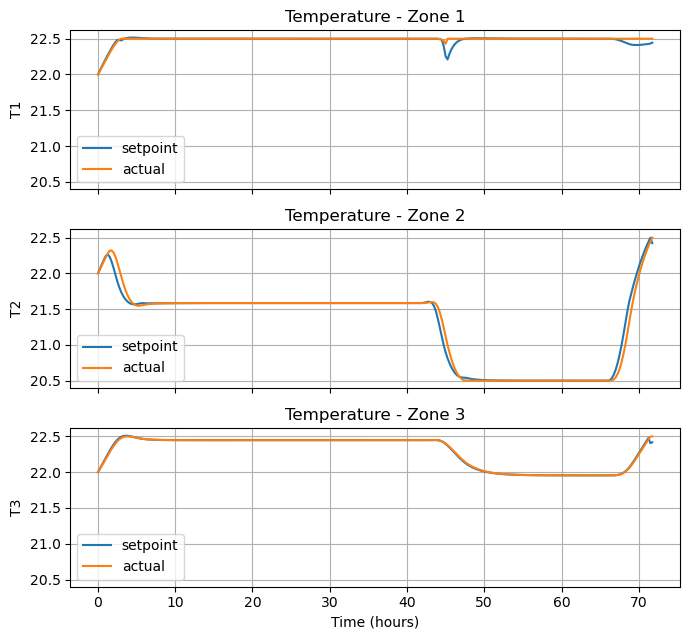

In [29]:
plot_data = {
    f"Temperature - Zone {z+1}": {
        "y": np.stack([U_sol[:, z], X_sol[:-1, z]]).T, 
        "labels": ['setpoint', 'actual'], 
        "y_label": f"T{z+1}"
    } 
    for z in range(n_z)
}
make_tsplots(t[:-1], plot_data, sharey=True)
plt.tight_layout()
plt.show()


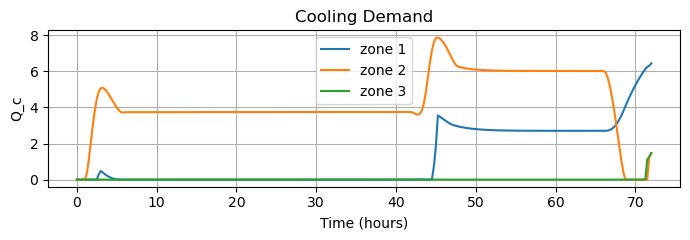

In [30]:
plot_data = {
    f"Cooling Demand": {
        "y": Y_sol, 
        "labels": [f"zone {i+1}" for i in range(n_z)], 
        "y_label": f"Q_c"
    }
}
make_tsplots(t, plot_data, sharey=True)
plt.tight_layout()
plt.show()

## Data from Stanford Case Study

This data was made available from:
- https://hvacstudy.github.io/

In [31]:
data_dir = "data"
filename = "data.mat"

data = scipy.io.matlab.loadmat(os.path.join(data_dir, filename), simplify_cells=True)
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'param', 'airside', 'waterside'])

In [32]:
{name: type(x) for name, x in data.items()}

{'__header__': bytes,
 '__version__': str,
 '__globals__': list,
 'param': dict,
 'airside': dict,
 'waterside': dict}

In [33]:
param = data['param']
param.keys()

dict_keys(['time', 'AmbientTemp', 'ElecPrices', 'DemandCharge', 'ComfortMin', 'ComfortMax', 'StorageCapacity'])

In [34]:
airside = data['airside']
airside.keys()

dict_keys(['H', 'C', 'Beta', 'Qss', 'Kc', 'tauI'])

In [35]:
waterside = data['waterside']
waterside.keys()

dict_keys(['common', 'chiller', 'pump', 'tower', 'tank'])

In [36]:
n_buildings = 25
assert data['airside']['C'].shape[0] == n_buildings

n_zones = 20
assert all([x.shape[0] for x in data['airside']['C']])


In [37]:
# Example of airside coefficients
building = 0
zone = 9
{p: airside[p][building][zone] for p in ['H', 'C', 'Qss', 'Kc', 'tauI']}

{'H': 15.14116470241531,
 'C': 438.2875387003527,
 'Qss': 0,
 'Kc': -560,
 'tauI': 1}

In [38]:
airside['Beta'][building][zone]

array([0.14570582, 0.13657539, 0.15410582, 0.15091977, 0.15063744,
       0.150666  , 0.14805606, 0.14147962, 0.14821616, 0.        ,
       0.14741695, 0.14932725, 0.14824992, 0.14464378, 0.14673437,
       0.14295033, 0.14881521, 0.14169108, 0.14196478, 0.14287258])

In [39]:
# Why are all the zones coupled almost equally?